# Residual model generation pipeline

In [1]:
import os
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt

import LMCE.cfusdlog as cfusdlog
import LMCE.uav_trajectory as uav_trajectory
from LMCE.model import MLP
from LMCE.residual_calculation import residual
from LMCE.data_prep import prepare_data, create_dataloader
from LMCE.model_to_c_conversion import exportNet, c_model_test
from LMCE.error_estimation import error_calculator, find_best_cutoff

## Preparing the data
First define where the data is stored, then it can be loaded, the `prepare_data` function calculates the labels (residual forces).

In [2]:
# Get train data paths
indices = [f"{i:02}" for i in range(0, 86)]
test_indices = [24]
for i in test_indices:
    del indices[i]
training_data_paths = [f"./crazyflie-data-collection/brushless_flights_payload/data/eckart{i}" for i in indices]
testing_data_paths = [f"./crazyflie-data-collection/brushless_flights_payload/data/eckart{i}" for i in test_indices]

# Prepare data
residual_func = lambda data: residual(data, is_brushless=True, has_payload=True, total_mass=.0444)
X_train, y_train = prepare_data(training_data_paths, save_as="train_data_payload", residual_func=residual_func, overwrite=False)
X_test, y_test = prepare_data(testing_data_paths, save_as="test_data_payload", shuffle_data=False, residual_func=residual_func, overwrite=False)
train_dataloader = create_dataloader(X_train, y_train)
test_dataloader = create_dataloader(X_test, y_test)

Data already exists, loading from files...
Data already exists, loading from files...


We can plot the flight path and residual forces like this

eckart24 mean residual f_x: -0.0012253659496272407
eckart24 mean residual f_y: 0.003721986609043854
eckart24 mean residual f_z: -0.006358993057366246


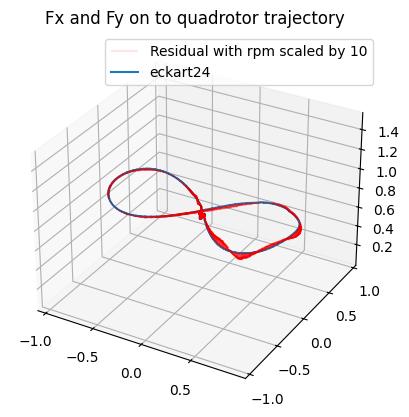

In [3]:
data_path = testing_data_paths[0]
visual_scale = 1.

fig = plt.figure()
ax = plt.axes(projection='3d')

data = cfusdlog.decode(data_path)['fixedFrequency']
label = os.path.basename(data_path)

x = [i for i in data["stateEstimate.x"]]
y = [i for i in data["stateEstimate.y"]]
z = [i for i in data["stateEstimate.z"]]
origin = np.array([x, y, z]).T

f, _ = residual_func(data)
vector = np.array([f[:, 0], f[:, 1], f[:, 2]]).T * visual_scale
ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2], vector[:, 0], vector[:, 1],
          vector[:, 2], color='r', alpha=.1, label="Residual with rpm scaled by 10")

ax.plot3D(x, y, z, label=label)

# Calculate the avg. residual force for each axis
for j, v in enumerate(["x", "y", "z"]):
    f_j = [f_[j] for f_ in f]
    print(f"{label} mean residual f_{v}: {sum(f_j)/len(f_j)}")

plt.title("Fx and Fy on to quadrotor trajectory")
plt.legend()
plt.axis('equal')
plt.show()

## Training the model

Epoch 1
-------------------------------
avg. train loss:  0.011387
Avg. test loss: 0.000182 


-------------------------------
Epoch 2
-------------------------------
avg. train loss:  0.000376
Avg. test loss: 0.000122 


-------------------------------
Epoch 3
-------------------------------
avg. train loss:  0.000211
Avg. test loss: 0.000094 


-------------------------------
Epoch 4
-------------------------------
avg. train loss:  0.000130
Avg. test loss: 0.000071 


-------------------------------
Epoch 5
-------------------------------
avg. train loss:  0.000096
Avg. test loss: 0.000059 


-------------------------------
Epoch 6
-------------------------------
avg. train loss:  0.000084
Avg. test loss: 0.000072 


-------------------------------
Epoch 7
-------------------------------
avg. train loss:  0.000081
Avg. test loss: 0.000069 


-------------------------------
Epoch 8
-------------------------------
avg. train loss:  0.000078
Avg. test loss: 0.000058 


----------------

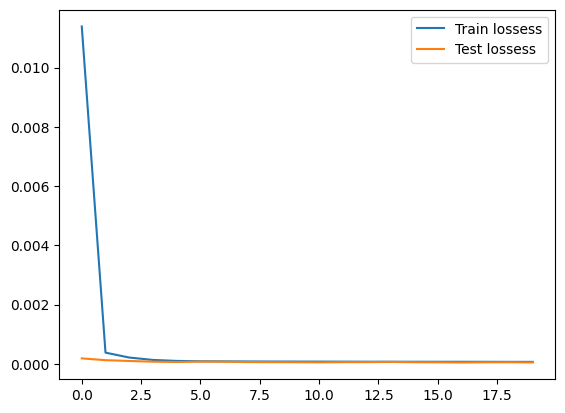

In [4]:
# Create and train neural network
model = MLP()
model.train_model(train_dataloader, test_dataloader, epochs=20)
model.show_progress()
model.save("model.pth")

## Testing the model

Average error: (x) -> 0.00492483879182957 (y) -> 0.0056808935626344575


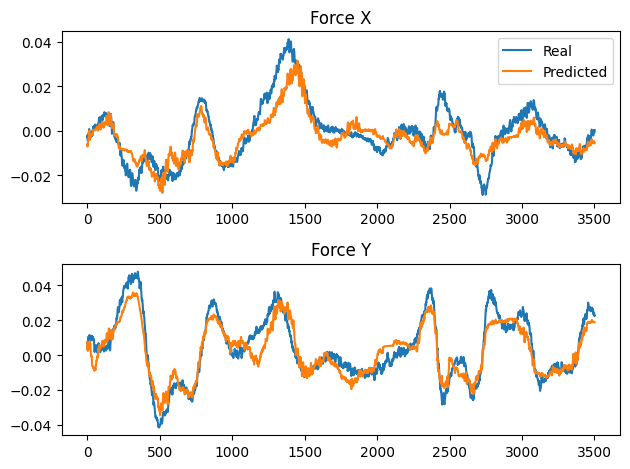

In [5]:
weights = torch.load('./models/model.pth')
model.load_state_dict(weights)

tensor_input = torch.from_numpy(X_test)
pred = model.forward(tensor_input).detach().numpy()
error = np.abs(y_test-pred)
print(f"Average error: (x) -> {np.mean(error[:, 0])} (y) -> {np.mean(error[:, 1])}")

fig, ax = plt.subplots(2)
ax[0].plot(y_test[:, 0], label="Real")
ax[0].plot(pred[:, 0], label="Predicted")
ax[0].set_title('Force X')

ax[1].plot(y_test[:, 1], label="Real")
ax[1].plot(pred[:, 1], label="Predicted")
ax[1].set_title('Force Y')

ax[0].legend()
plt.tight_layout()
plt.show()

## Translating the model to c code

In [6]:
# Generate the model c code
model_path = "./models/model.pth"
exportNet(model_path)

# Test if the generated model gives the same outputs as the original
c_model_test(model, "./data/test_data_payload.npz")

Comparing with original...
Models give the same outputs!


## Adding the model to the cf-firmware

In [7]:
shutil.copyfile("./LMCE/c_utils/nn.c", "./crazyflie-firmware/src/modules/src/controller/nn.c")
shutil.copyfile("./LMCE/c_utils/nn.h", "./crazyflie-firmware/src/modules/interface/controller/nn.h")

'./crazyflie-firmware/src/modules/interface/controller/nn.h'

## Error calculation
For calculating the error with the addition of the learning models the flights need to be re-recorded with the updated firmware.

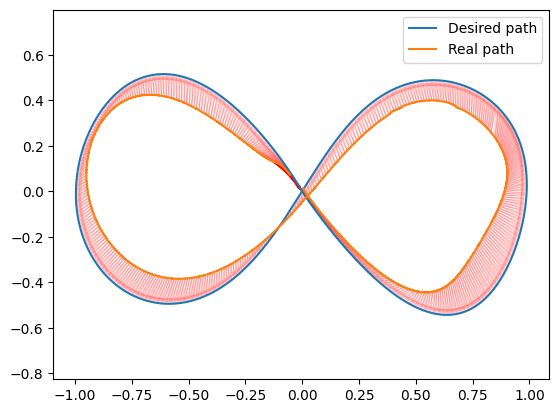

Avg. error: 0.0859 (m)


In [11]:
# Get desired path
traj = uav_trajectory.Trajectory()
traj.loadcsv("./LMCE/flight_paths/figure8.csv")
traj.stretchtime(2)

ts = np.arange(0, traj.duration, 0.01)
evals = np.empty((len(ts), 15))
for t, i in zip(ts, range(0, len(ts))):
    e = traj.eval(t)
    e.pos += np.array([0, 0, 1])
    evals[i, 0:3] = e.pos

target_pos = evals.transpose()

# Get real path
data_path = testing_data_paths[0]
data = cfusdlog.decode(data_path)['fixedFrequency']
real_pos = [data["stateEstimate.x"], data["stateEstimate.y"]]

# Calculate error
cutoff = find_best_cutoff(real_pos, target_pos)
avg_error = error_calculator(cutoff, real_pos, target_pos, vis=True)
print(f"Avg. error: {avg_error:.4f} (m)")